In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, models, layers
from keras.applications import VGG16

import os

import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

### Steps for fine-tuning a network are as follow:
#### 1. Add your custom network on top of an already-trained base network.
#### 2. Freeze the base network.
#### 3. Train the part you added.
#### 4. Unfreeze some layers in the base network.
#### 5. Jointly train both these layers and the part you added

In [2]:
# Load the Trained model (part 3 from above)
with open('models/cats_and_dog_VGG16_2_architecture.json','r') as f:
    model = models.model_from_json(f.read())

model.load_weights('models/cats_and_dog_VGG16_2_weights.h5')

model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [3]:
# vgg16 model
model.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
model.layers[0].trainable = True

# set layers trainable after a particular layer
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 6,817,281
Non-trainable params: 9,995,072
_________________________________________________________________


In [6]:
# VGG layers summary
model.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [7]:
print('-----Full Model-----')
for layer in model.layers:
    print(layer.name, layer.trainable)

print('-----For VGG16 Layers-----')
for layer in model.layers[0].layers:
    print(layer.name, layer.trainable)

-----Full Model-----
vgg16 True
flatten_1 True
dense_3 True
dense_4 True
-----For VGG16 Layers-----
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 True
block5_conv3 True
block5_pool True


In [8]:
# compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


In [9]:
# data preparation
base_dir = 'data/cats_and_dogs_small'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

train_datagen = ImageDataGenerator(rescale=1./255,
                          rotation_range=40,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                           target_size=(150,150),
                           batch_size=20,
                           class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                           target_size=(150,150),
                           batch_size=20,
                           class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                           target_size=(150,150),
                           batch_size=20,
                           class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# # train mode
# history = model.fit_generator(train_generator,
#                              steps_per_epoch=100,
#                              epochs=30,
#                              validation_data=validation_generator,
#                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 420s 4s/step - loss: 0.2762 - acc: 0.8705 - val_loss: 0.2442 - val_acc: 0.8990
Epoch 2/30
100/100 [==============================] - 414s 4s/step - loss: 0.2673 - acc: 0.8820 - val_loss: 0.2254 - val_acc: 0.9070
Epoch 3/30
100/100 [==============================] - 413s 4s/step - loss: 0.2471 - acc: 0.8945 - val_loss: 0.2377 - val_acc: 0.9060
Epoch 4/30
100/100 [==============================] - 413s 4s/step - loss: 0.2521 - acc: 0.9020 - val_loss: 0.2136 - val_acc: 0.9160
Epoch 5/30
100/100 [==============================] - 415s 4s/step - loss: 0.2195 - acc: 0.9110 - val_loss: 0.2033 - val_acc: 0.9200
Epoch 6/30
100/100 [==============================] - 417s 4s/step - loss: 0.2188 - acc: 0.9155 - val_loss: 0.2218 - val_acc: 0.9120
Epoch 7/30
100/100 [==============================] - 415s 4s/step - loss: 0.2171 - acc: 0.9140 - val_loss: 0.2010 - val_acc: 0.9180
Epoch 8/30
100/100 [==============================] - 414s 4s/step - 

In [13]:
# # save model weights
# model.save_weights('models/cats_and_dog_finetuned_weights.h5')

# # save model architecture
# with open('models/cats_and_dog_finetuned_architecture.json','w') as f:
#     f.write(model.to_json())
    
# # # save model training history
# pd.DataFrame(history.history).to_csv('models/cats_and_dog_finetuned.csv',index=False)

In [ ]:
# # Preferred way to load model
# load model architecture
with open('models/cats_and_dog_finetuned_architecture.json','r') as f:
    model = models.model_from_json(f.read())
    
# load weights into the model
model.load_weights('models/cats_and_dog_finetuned_weights.h5')

# load model training history
history = pd.read_csv('models/cats_and_dog_finetuned.csv')

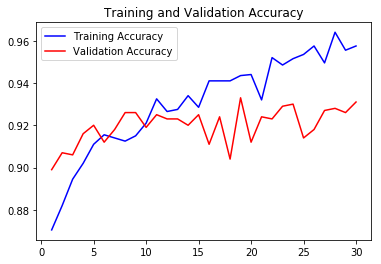

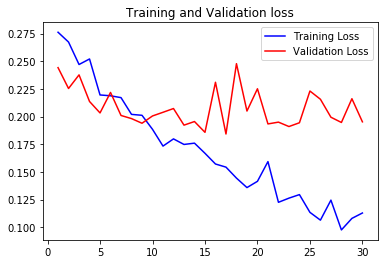

In [20]:
#  plot

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend();

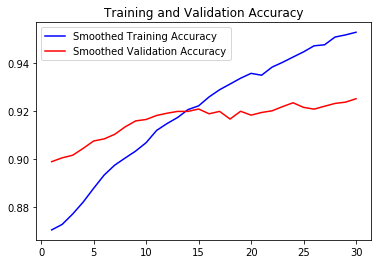

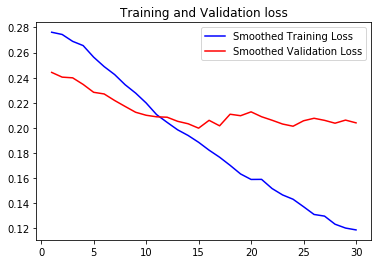

In [21]:
# smoothed curve
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'b', label='Smoothed Training Accuracy')
plt.plot(epochs, smooth_curve(val_acc), 'r', label='Smoothed Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, smooth_curve(loss), 'b', label='Smoothed Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='Smoothed Validation Loss')
plt.title('Training and Validation loss')
plt.legend();

In [14]:
test_loss, test_acc = model.evaluate_generator(test_generator,steps=50)
print('Test Loss:',test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.20873148397775368
Test Accuracy: 0.9279999947547912
